# $\chi^2$-test

In [35]:
import math
from random import choices

import numpy as np
import seaborn as sns
from numpy.testing import assert_almost_equal as almost_equal
from scipy.integrate import quad

### Bin counts

In [36]:
from src.tvla.chi2 import chi_squared as chi_squared_balanced

In [37]:
def count(traces, poi=None, trace_range=256, offset=-.5, max_bins=64):
    pos_traces = traces + round(-trace_range * offset)

    if poi is None:
        poi = (0, traces.shape[1])

    bin_count = np.sum(np.array([np.bincount(sample_pts[poi[0]:poi[1]], minlength=trace_range) for sample_pts in pos_traces]), axis=0)

    res = np.zeros(max_bins)
    step = round(trace_range / max_bins)

    for ix in range(max_bins):
        res[ix] = np.sum(bin_count[ix * step:(ix + 1) * step])

    return res


### Test examples from paper
Moriadi et al. (2018), page 214

In [38]:
# Example values from Moriadi et al. (2018), page 214
MORIADI = {
    'F_0': [24, 59, 28, 9],
    'F_1': [23, 57, 20, 0],
    'chi': 8.64,
    'dof': 3,
    'p': 0.0345,
    'p_decimal': 3
}

In [39]:
DEN_CACHE, EXP_CACHE = {}, {}

for i in range(1, 64 + 1):
    DEN_CACHE[i] = 1 / (2 ** (i / 2) * math.gamma(i / 2))
    EXP_CACHE[i] = ((i / 2) - 1)

In [40]:
def make_f_chi(v):
    def f_chi(x: float) -> float:
        if x <= 0:
            return 0.0

        num = x ** EXP_CACHE[v] * math.e ** (x * -.5)
        return num * DEN_CACHE[v]

    return f_chi

def p_chi(sum_chi, dof):
    return quad(make_f_chi(dof), sum_chi, np.inf)[0]


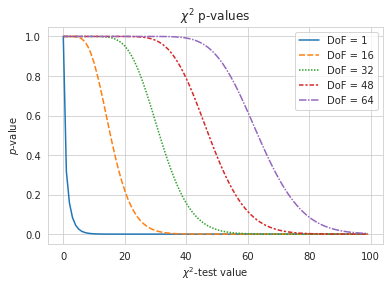

In [41]:
from pandas import DataFrame as Df

def plot_chi():
    sns.set_style("whitegrid")
    chi_range = np.arange(0, 100, 1)

    plots = {}
    for dof in [1, 16, 32, 48, 64]:
        plots[f"DoF = {dof}"] = [p_chi(chi, dof) for chi in chi_range]

    sns.lineplot(data=Df(plots).set_index(chi_range))\
        .set(title="$\chi^2$ p-values", xlabel="$\chi^2$-test value", ylabel="$p$-value")

plot_chi()

In [42]:
almost_equal(p_chi(MORIADI['chi'], MORIADI['dof']), MORIADI['p'], MORIADI['p_decimal'])

### Implementation of $\chi^2$-test

### Implementation based on paper
Moriadi et al. (2018), page 213

In [43]:
def chi_squared_paper(observed, expected, balance=False):
    categories = np.array([observed, expected])

    # Expected frequency
    sum_cat = np.sum(observed), np.sum(expected)

    sum_oe = np.sum(categories, axis=0)

    sum_all = np.sum(sum_oe)
    nz_ixs = np.nonzero(sum_oe)[0]

    chi_acc = 0.0
    for cat in range(len(categories)):
        for ix in nz_ixs:
            # Expected frequency
            ef = (sum_cat[cat] * sum_oe[ix]) / sum_all
            # Accumulation of chi-squared value
            chi_acc += (categories[cat][ix] - ef) ** 2 / ef

    # Degrees of freedom.
    dof = (len(nz_ixs) - 1) * (len(categories) - 1)

    # return chi_acc, dof
    return p_chi(chi_acc, dof)

almost_equal(chi_squared_paper(MORIADI['F_0'], MORIADI['F_1']), MORIADI['p'], MORIADI['p_decimal'])

In [44]:
NUM_CATEGORIES = 2
NUM_CAT_DOF = NUM_CATEGORIES - 1
RANGE_CAT = range(NUM_CATEGORIES)

def chi_squared_quicker(observed, expected):
    categories = np.array([observed, expected])

    sum_categories = np.sum(categories, axis=0)
    sum_counts = np.sum(observed), np.sum(expected)
    sum_all = np.sum(sum_counts)

    nonzero = sum_categories.astype(bool)
    nonzero_cat_sum = sum_categories[nonzero]

    expected_frequencies = (np.array(sum_counts) * nonzero_cat_sum.reshape(-1, 1)).T / sum_all

    chi_acc = ((categories[:, nonzero] - expected_frequencies) ** 2 / expected_frequencies).sum()

    # Degrees of freedom.
    dof = (len(nonzero_cat_sum) - 1) * NUM_CAT_DOF

    # return chi_acc, dof
    return p_chi(chi_acc, dof)

chi_squared_quicker(MORIADI['F_0'], MORIADI['F_1'])
# almost_equal(chi_squared_quick(MORIADI['F_0'], MORIADI['F_1']), MORIADI['p'], MORIADI['p_decimal'])

0.034444325563512325

In [45]:
sum(MORIADI['F_0']), sum(MORIADI['F_1'])

MORIADI['F_0'], MORIADI['F_1'] = np.array(MORIADI['F_0']), np.array(MORIADI['F_1'])

cs = lambda w, k: choices(list(range(len(MORIADI['F_1']))), weights=w, k=k)
np.add.at(MORIADI['F_1'], cs(MORIADI['F_1'], sum(MORIADI['F_0']) - sum(MORIADI['F_1'])), 1)

sum(MORIADI['F_0']), sum(MORIADI['F_1'])

(120, 120)

In [46]:
assert chi_squared_balanced([*MORIADI['F_0'], 0], [*MORIADI['F_1'], 0]) == chi_squared_quicker(MORIADI['F_0'], MORIADI['F_1'])

In [47]:
assert False

AssertionError: 

In [ ]:
F0 = [*MORIADI["F_0"], *[0] * 20]
F1 = [*MORIADI["F_1"], *[0] * 20]

SUM_TIM = 0.0
for _ in tqdm(range(100)):
    SUM_TIM += timeit.timeit(lambda: chi_squared_quicker(F0, F1), number=1000) - \
    timeit.timeit(lambda: chi_squared_balanced(F0, F1), number=1000)

SUM_TIM

In [ ]:
timeit.timeit(lambda: chi_squared_balanced(MORIADI["F_0"], MORIADI["F_1"]), number=10000), \
timeit.timeit(lambda: chi_squared_quicker(MORIADI["F_0"], MORIADI["F_1"]), number=10000)

In [ ]:
0.6451343500084477